In [22]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import os
import pickle

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import PredefinedSplit

# Define the function to find the best number of trees (from the earlier example)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
X_train = pd.read_csv('datasets/final_data_train_delivery1.csv', index_col=0)
y_train = pd.read_csv('datasets/scaled_target_train_delivery1.csv', index_col=0)
X_val = pd.read_csv('datasets/final_data_val_delivery1.csv', index_col=0)
y_val = pd.read_csv('datasets/scaled_target_val_delivery1.csv', index_col=0)
X_test = pd.read_csv('datasets/final_data_test_delivery1.csv', index_col=0)

# 4. Modelling

## Baseline

In [26]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Compute metrics
    metrics = {
        "Train Accuracy": accuracy_score(y_train, train_preds),
        "Validation Accuracy": accuracy_score(y_val, val_preds),
        "Train F1 Macro": f1_score(y_train, train_preds, average='macro'),
        "Validation F1 Macro": f1_score(y_val, val_preds, average='macro')
    }
    
    # Print metrics
    print("Training Data Evaluation:")
    print(f"Accuracy (Train): {metrics['Train Accuracy']:.4f}")
    print(f"F1 Macro (Train): {metrics['Train F1 Macro']:.4f}")
    
    print("\nValidation Data Evaluation:")
    print(f"Accuracy (Validation): {metrics['Validation Accuracy']:.4f}")
    print(f"F1 Macro (Validation): {metrics['Validation F1 Macro']:.4f}")
    
    print("\nClassification Report (Validation):")
    print(classification_report(y_val, val_preds))

    # Determine class labels from y_train for the confusion matrix
    labels = np.unique(y_train)  # Get unique labels directly from the training data
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return metrics


### **Logistic Regression (Baseline)**

Training Data Evaluation:
Accuracy (Train): 0.6590
F1 Macro (Train): 0.2291

Validation Data Evaluation:
Accuracy (Validation): 0.6589
F1 Macro (Validation): 0.2268

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.29      0.00      0.00      2044
           1       0.71      0.94      0.81     56770
           2       0.26      0.00      0.01     13355
           3       0.56      0.56      0.56     28361
           4       0.56      0.36      0.44      9124
           5       0.00      0.00      0.00       827
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00        87

    accuracy                           0.66    110586
   macro avg       0.30      0.23      0.23    110586
weighted avg       0.59      0.66      0.60    110586



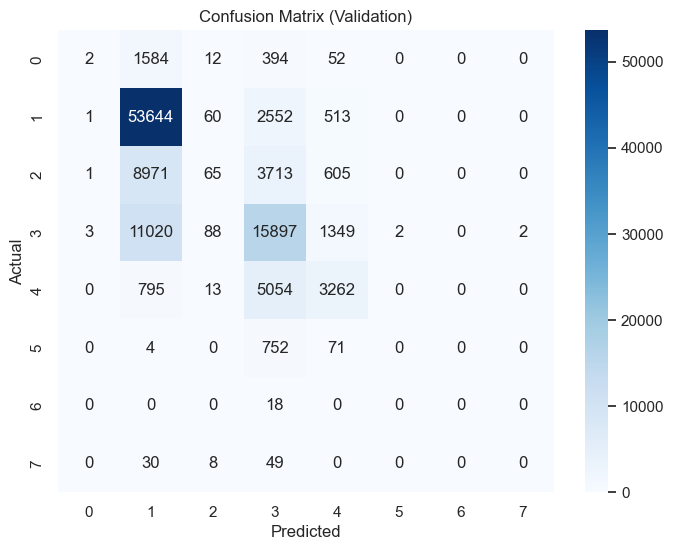

In [27]:
lr = LogisticRegression()
lr_metrics = evaluate_model(lr, X_train, y_train, X_val, y_val)

### **Random Forest (Baseline)**

Training Data Evaluation:
Accuracy (Train): 0.9974
F1 Macro (Train): 0.9966

Validation Data Evaluation:
Accuracy (Validation): 0.7205
F1 Macro (Validation): 0.3084

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.42      0.12      0.19      2044
           1       0.78      0.95      0.86     56770
           2       0.36      0.06      0.10     13355
           3       0.64      0.72      0.68     28361
           4       0.62      0.47      0.54      9124
           5       0.00      0.00      0.00       827
           6       0.00      0.00      0.00        18
           7       0.23      0.07      0.11        87

    accuracy                           0.72    110586
   macro avg       0.38      0.30      0.31    110586
weighted avg       0.67      0.72      0.67    110586



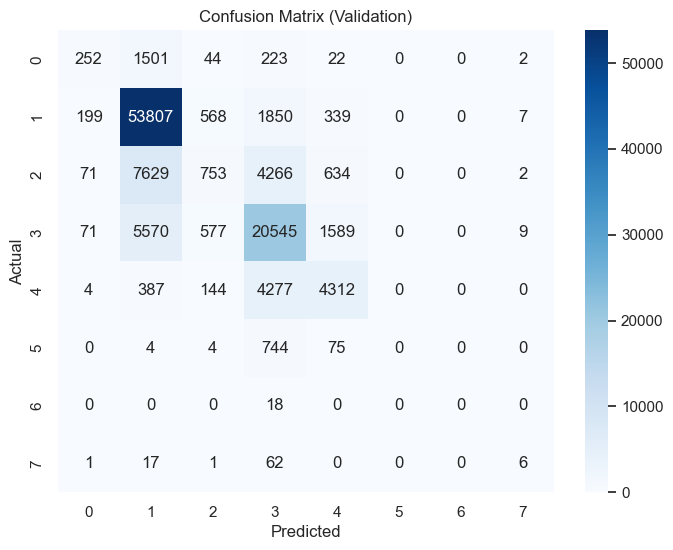

In [29]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_metrics = evaluate_model(rf, X_train, y_train, X_val, y_val)

### **AdaBoost**

Training Data Evaluation:
Accuracy (Train): 0.6527
F1 Macro (Train): 0.2560

Validation Data Evaluation:
Accuracy (Validation): 0.6544
F1 Macro (Validation): 0.2576

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.08      0.00      0.00      2044
           1       0.69      0.96      0.80     56770
           2       0.28      0.01      0.03     13355
           3       0.59      0.47      0.52     28361
           4       0.54      0.48      0.51      9124
           5       0.00      0.00      0.00       827
           6       0.01      0.06      0.01        18
           7       0.11      0.59      0.18        87

    accuracy                           0.65    110586
   macro avg       0.29      0.32      0.26    110586
weighted avg       0.59      0.65      0.59    110586



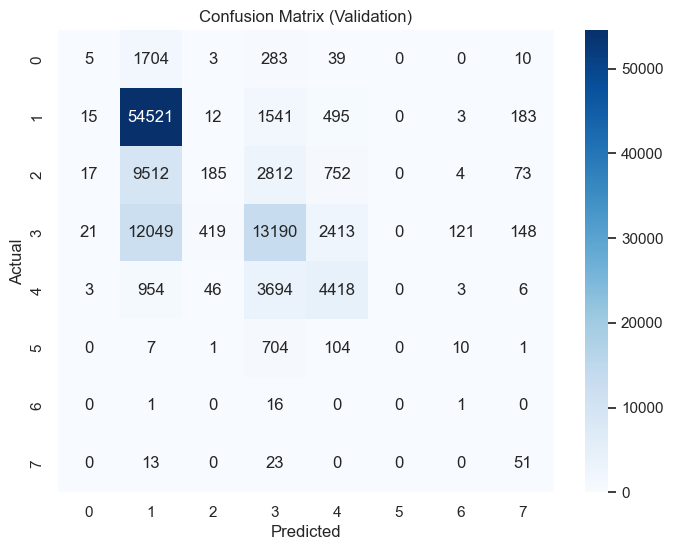

In [30]:
adaboost = AdaBoostClassifier(random_state=42)
adaboost_metrics = evaluate_model(adaboost, X_train, y_train, X_val, y_val)

### **Gradient Boosting**

Training Data Evaluation:
Accuracy (Train): 0.7267
F1 Macro (Train): 0.3793

Validation Data Evaluation:
Accuracy (Validation): 0.7256
F1 Macro (Validation): 0.3060

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.43      0.12      0.19      2044
           1       0.77      0.97      0.86     56770
           2       0.44      0.03      0.06     13355
           3       0.66      0.72      0.69     28361
           4       0.58      0.47      0.52      9124
           5       0.20      0.00      0.00       827
           6       0.00      0.00      0.00        18
           7       0.22      0.09      0.13        87

    accuracy                           0.73    110586
   macro avg       0.41      0.30      0.31    110586
weighted avg       0.68      0.73      0.67    110586



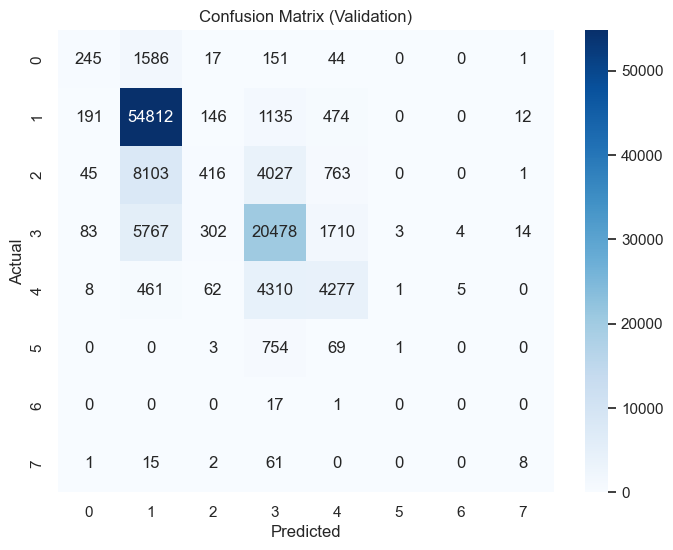

In [31]:
gb = GradientBoostingClassifier(random_state=42)
gb_metrics = evaluate_model(gb, X_train, y_train, X_val, y_val)

### **HistGradientBoosting**

Training Data Evaluation:
Accuracy (Train): 0.7147
F1 Macro (Train): 0.3137

Validation Data Evaluation:
Accuracy (Validation): 0.7144
F1 Macro (Validation): 0.3024

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.48      0.12      0.19      2044
           1       0.76      0.96      0.85     56770
           2       0.63      0.01      0.01     13355
           3       0.63      0.72      0.67     28361
           4       0.64      0.41      0.50      9124
           5       0.19      0.01      0.02       827
           6       0.01      0.06      0.02        18
           7       0.11      0.25      0.15        87

    accuracy                           0.71    110586
   macro avg       0.43      0.32      0.30    110586
weighted avg       0.69      0.71      0.66    110586



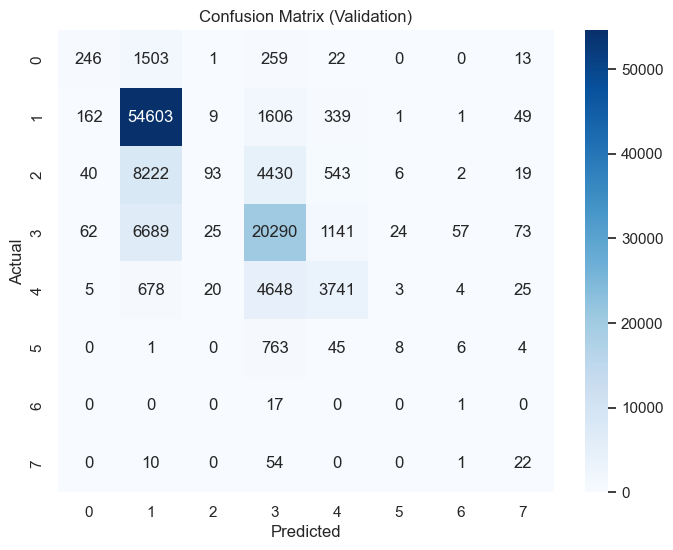

In [32]:
hist_gb = HistGradientBoostingClassifier(random_state=42)
hist_gb_metrics = evaluate_model(hist_gb, X_train, y_train, X_val, y_val)

### **NaiveBayes**

Training Data Evaluation:
Accuracy (Train): 0.5135
F1 Macro (Train): 0.2055

Validation Data Evaluation:
Accuracy (Validation): 0.5138
F1 Macro (Validation): 0.2061

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.21      0.34      0.26      2044
           1       0.75      0.89      0.81     56770
           2       0.20      0.07      0.10     13355
           3       0.49      0.09      0.15     28361
           4       0.46      0.24      0.32      9124
           5       0.00      0.00      0.00       827
           6       0.00      0.94      0.00        18
           7       0.01      0.14      0.01        87

    accuracy                           0.51    110586
   macro avg       0.26      0.34      0.21    110586
weighted avg       0.57      0.51      0.50    110586



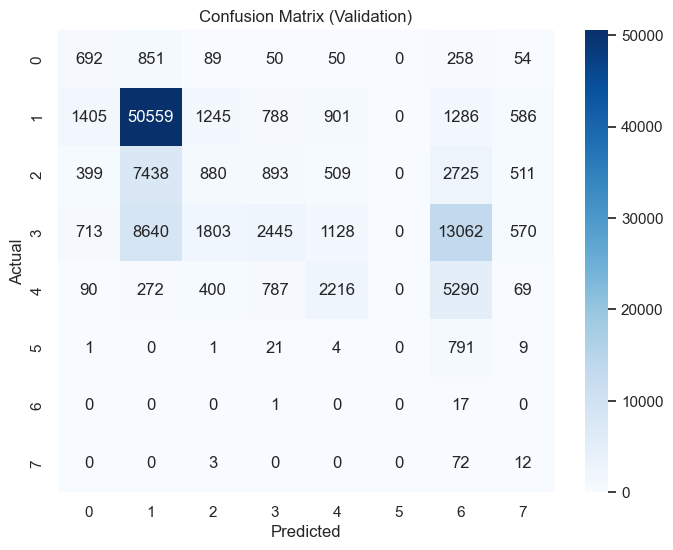

In [33]:
# Initialize the Gaussian Naive Bayes model with variance smoothing
gnb_model = GaussianNB()
gnb_metrics = evaluate_model(gnb_model, X_train, y_train, X_val, y_val)

### **MultiLayerPerceptron**

Training Data Evaluation:
Accuracy (Train): 0.7040
F1 Macro (Train): 0.3123

Validation Data Evaluation:
Accuracy (Validation): 0.7020
F1 Macro (Validation): 0.3049

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.42      0.15      0.22      2044
           1       0.75      0.95      0.84     56770
           2       0.36      0.04      0.07     13355
           3       0.62      0.66      0.64     28361
           4       0.62      0.49      0.55      9124
           5       1.00      0.00      0.00       827
           6       0.00      0.00      0.00        18
           7       0.28      0.08      0.12        87

    accuracy                           0.70    110586
   macro avg       0.51      0.29      0.30    110586
weighted avg       0.66      0.70      0.65    110586



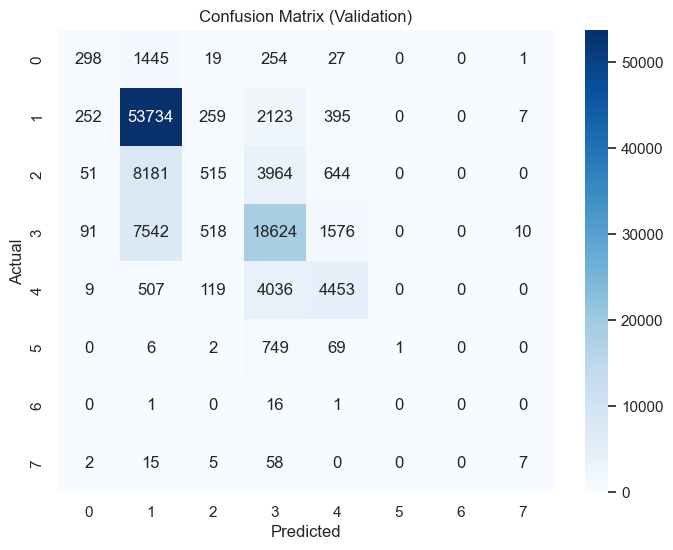

In [34]:
mlp = MLPClassifier(random_state=42)
mlp_metrics = evaluate_model(mlp, X_train, y_train, X_val, y_val)

### **KNN**

Training Data Evaluation:
Accuracy (Train): 0.7612
F1 Macro (Train): 0.4195

Validation Data Evaluation:
Accuracy (Validation): 0.6914
F1 Macro (Validation): 0.3071

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.30      0.18      0.23      2044
           1       0.77      0.94      0.84     56770
           2       0.22      0.10      0.14     13355
           3       0.65      0.62      0.64     28361
           4       0.58      0.42      0.49      9124
           5       0.11      0.01      0.01       827
           6       0.00      0.00      0.00        18
           7       0.32      0.07      0.11        87

    accuracy                           0.69    110586
   macro avg       0.37      0.29      0.31    110586
weighted avg       0.64      0.69      0.66    110586



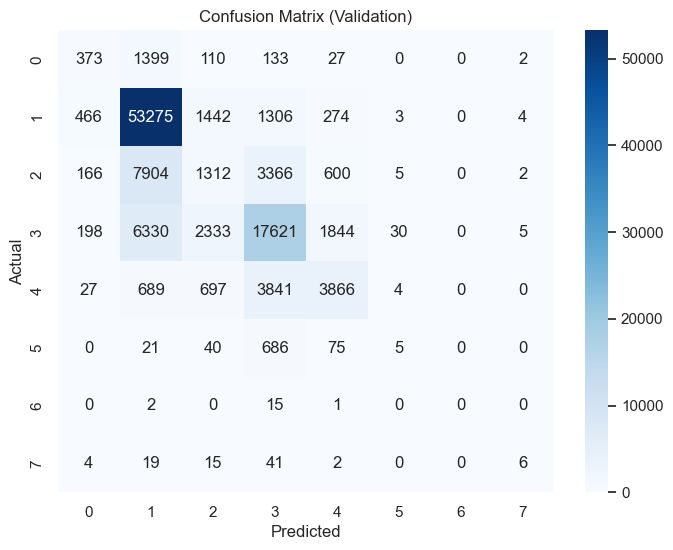

In [35]:
knn = KNeighborsClassifier()
knn_metrics = evaluate_model(knn, X_train, y_train, X_val, y_val)

### **XG Boost**

Training Data Evaluation:
Accuracy (Train): 0.7853
F1 Macro (Train): 0.5519

Validation Data Evaluation:
Accuracy (Validation): 0.7741
F1 Macro (Validation): 0.3522

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.52      0.15      0.24      2044
           1       0.83      0.98      0.90     56770
           2       0.43      0.05      0.08     13355
           3       0.71      0.86      0.77     28361
           4       0.65      0.52      0.58      9124
           5       0.00      0.00      0.00       827
           6       0.00      0.00      0.00        18
           7       0.33      0.20      0.24        87

    accuracy                           0.77    110586
   macro avg       0.43      0.34      0.35    110586
weighted avg       0.72      0.77      0.72    110586



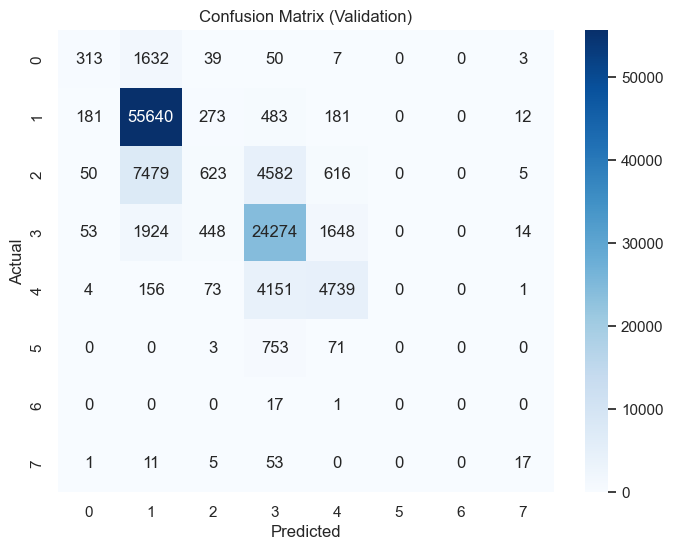

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
xgb_metrics = evaluate_model(xgb, X_train, y_train, X_val, y_val)

### **Bagging Classifier**

Training Data Evaluation:
Accuracy (Train): 0.9792
F1 Macro (Train): 0.9634

Validation Data Evaluation:
Accuracy (Validation): 0.7244
F1 Macro (Validation): 0.3368

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.31      0.18      0.23      2044
           1       0.82      0.94      0.87     56770
           2       0.25      0.11      0.16     13355
           3       0.67      0.73      0.70     28361
           4       0.58      0.47      0.52      9124
           5       0.10      0.01      0.02       827
           6       0.00      0.00      0.00        18
           7       0.39      0.14      0.20        87

    accuracy                           0.72    110586
   macro avg       0.39      0.32      0.34    110586
weighted avg       0.68      0.72      0.69    110586



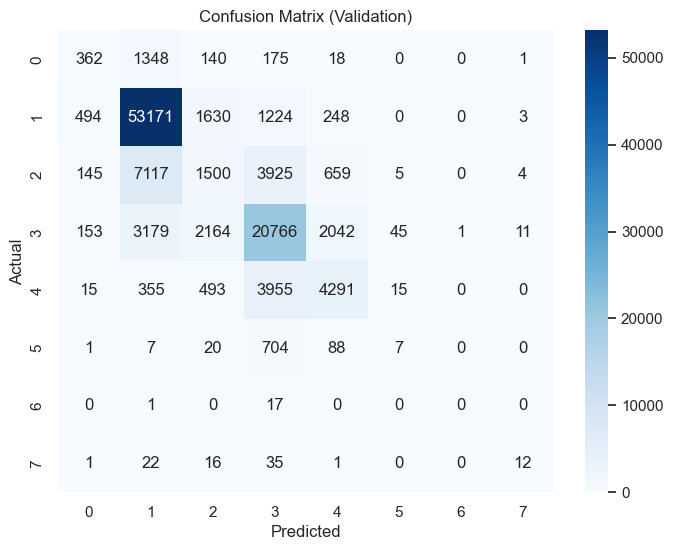

In [37]:
from sklearn.ensemble import BaggingClassifier

# Initialize the BaggingClassifier
bagging = BaggingClassifier(random_state=42)

# Evaluate the BaggingClassifier
bagging_metrics = evaluate_model(bagging, X_train, y_train, X_val, y_val)

### **Comparisons**

In [38]:
# create a dataframe to store the metrics
metrics_df = pd.DataFrame([lr_metrics, rf_metrics, adaboost_metrics, gb_metrics, hist_gb_metrics, gnb_metrics, mlp_metrics, knn_metrics, xgb_metrics, bagging_metrics],
                          index=['Logistic Regression', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'HistGradientBoosting', 'Naive Bayes', 'MLP', 'KNN', 'XGBoost', 'Bagging'])

metrics_df

,Train Accuracy,Validation Accuracy,Train F1 Macro,Validation F1 Macro
Logistic Regression,0.658991,0.658944,0.229066,0.226847
Random Forest,0.997447,0.720480,0.996551,0.308426
AdaBoost,0.652740,0.654432,0.256030,0.257648
Gradient Boosting,0.726671,0.725562,0.379323,0.305993
HistGradientBoosting,0.714731,0.714412,0.313731,0.302401
Naive Bayes,0.513508,0.513817,0.205459,0.206105
MLP,0.704034,0.702006,0.312264,0.304900
KNN,0.761188,0.691390,0.419514,0.307063
XGBoost,0.785301,0.774112,0.551875,0.352236
Bagging,0.979188,0.724405,0.963372,0.336796


<Figure size 1200x600 with 0 Axes>

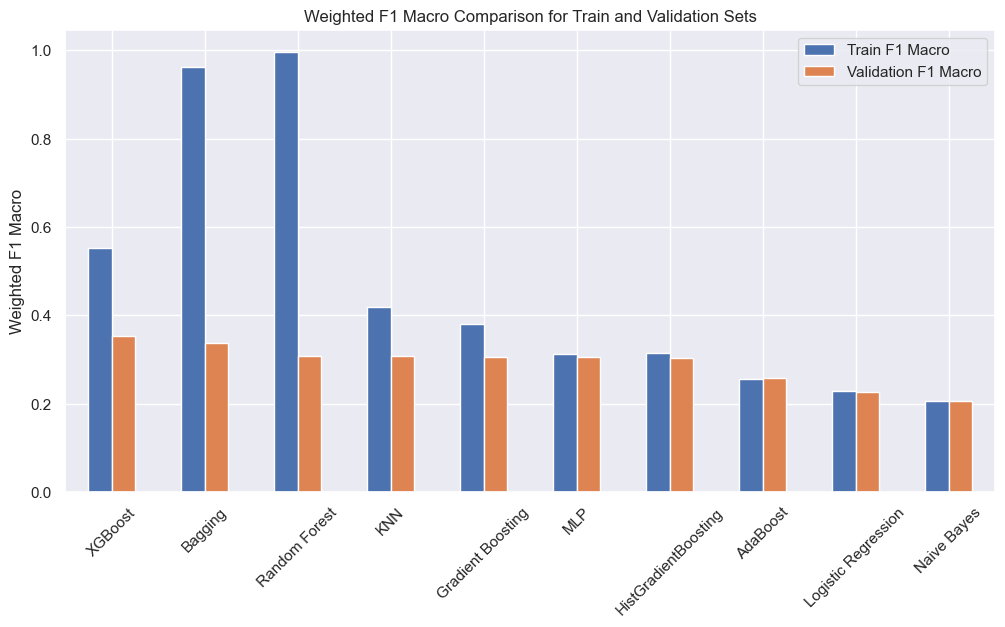

In [40]:
# create a plot comparing f1 scores for train and validation sets

def plot_metrics_df(metrics_df):
    plt.figure(figsize=(12, 6))
    metrics_df.sort_values('Validation F1 Macro', ascending=False, inplace=True)
    metrics_df[['Train F1 Macro', 'Validation F1 Macro']].plot(kind='bar', figsize=(12, 6), rot=45)
    plt.ylabel('F1 Macro')
    plt.title('F1 Macro Comparison for Train and Validation Sets')
    plt.show()

plot_metrics_df(metrics_df)


## Model Optimization

After evaluating baseline models, the goal now is to improve the performance of the best ones through hyperparameter tuning.

- Random Forest
- MLP
- XGBoost
- Bagging

### **Setting up Predefined Split** (Using the same we used for RFE)

In [41]:
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

# Create the test_fold array
test_fold = np.concatenate([
    np.full(len(X_train), -1),  # Assign -1 for training samples
    np.full(len(X_val), 0)     # Assign 0 for validation samples
])

# Define PredefinedSplit object
cv_strategy = PredefinedSplit(test_fold)

In [42]:
# calculation of class weights
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_combined), y=y_combined.values.ravel())
class_weight_dict = dict(zip(np.unique(y_combined), class_weights))

### **Random Forest (Optimized)**

In [ ]:
# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),       # Randomly sample n_estimators from 10 to 500
    'max_depth': [5, 8, 10, 20],            # Maximum depth of the tree
    'min_samples_split': [100, 500, 1000, 5000],   # Minimum samples required to split an internal node
    'min_samples_leaf': [100, 500, 1000, 5000]  # Minimum samples required to be at a leaf node
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                # Number of parameter settings to sample
    cv=cv_strategy,           # Use PredefinedSplit for cross-validation
    scoring='f1_macro',       # Optimize for F1 Macro score
    verbose=2,
    n_jobs=-1,                # Use all available processors
    random_state=42           # For reproducibility
)

# Fit RandomizedSearchCV
random_search.fit(X_combined, y_combined)

# Get the best parameters and model
best_params_rf = random_search.best_params_
best_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42,
    class_weight=class_weight_dict
)
best_rf.fit(X_combined, y_combined)

print(f"Best parameters: {best_params_rf}")

Fitting 1 folds for each of 50 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

[CV] END max_depth=10, min_samples_leaf=5000, min_samples_split=100, n_estimators=120; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=5000, n_estimators=230; total time= 2.2min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=100, n_estimators=260; total time= 2.5min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=5000, min_samples_split=100, n_estimators=370; total time= 3.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=500, min_samples_split=1000, n_estimators=314; total time= 4.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=500, n_estimators=443; total time= 5.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=100, min_samples_split=100, n_estimators=158; total time= 3.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=5000, n_estimators=472; total time= 5.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=1000, min_samples_split=5000, n_estimators=154; total time= 1.7min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=500, min_samples_split=5000, n_estimators=287; total time= 3.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=1000, n_estimators=120; total time=  56.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=500, n_estimators=352; total time= 5.8min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=100, n_estimators=230; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=500, n_estimators=274; total time= 4.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=500, n_estimators=485; total time= 7.9min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=500, n_estimators=152; total time= 1.8min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=500, n_estimators=341; total time= 2.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=500, n_estimators=487; total time= 4.2min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=500, min_samples_split=500, n_estimators=153; total time= 2.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=500, n_estimators=180; total time= 2.7min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=5000, min_samples_split=500, n_estimators=290; total time= 3.3min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=5000, min_samples_split=5000, n_estimators=466; total time= 5.0min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=500, min_samples_split=5000, n_estimators=261; total time= 3.5min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=5000, n_estimators=363; total time= 5.7min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=5000, n_estimators=140; total time= 1.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=5000, min_samples_split=1000, n_estimators=314; total time= 3.7min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=100, n_estimators=164; total time= 1.4min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=500, min_samples_split=5000, n_estimators=369; total time= 4.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=100, n_estimators=437; total time= 3.6min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=5000, n_estimators=162; total time= 1.2min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=5000, n_estimators=487; total time= 7.7min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=100, min_samples_split=5000, n_estimators=316; total time= 4.2min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=500, min_samples_split=1000, n_estimators=140; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# Extract the relevant data from the random search results
cv_results = random_search.cv_results_

# Create a DataFrame for easy analysis
results_df = pd.DataFrame(cv_results)

# Sort results by n_estimators for better visualization
results_df = results_df.sort_values('param_n_estimators')

# Filter the results for the 'n_estimators' and 'mean_test_score'
n_estimators = results_df['param_n_estimators']
f1_macro_scores = results_df['mean_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(n_estimators, f1_macro_scores, alpha=0.5, color='b', label='Individual trials')
plt.title("F1 Macro Score vs. Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("F1 Macro Score (Cross-Validation)")
plt.legend()
plt.grid(True)
plt.show()

# Print best score and corresponding n_estimators
best_idx = results_df['mean_test_score'].idxmax()
print(f"Best F1 Macro Score: {results_df.loc[best_idx, 'mean_test_score']:.4f}")
print(f"Number of Estimators: {results_df.loc[best_idx, 'param_n_estimators']}")

In [ ]:
# Train the final RandomForestClassifier model using the optimal number of estimators
rf_final = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42,
    class_weight=class_weight_dict
)

# Evaluate the model using the `evaluate_model` function
rf_optimized_final_metrics = evaluate_model(rf_final, X_train, y_train, X_val, y_val)

# Add metrics to metrics_df
metrics_df.loc['Random Forest (Optimized)'] = [
    rf_optimized_final_metrics['Train Accuracy'],
    rf_optimized_final_metrics['Validation Accuracy'],
    rf_optimized_final_metrics['Train F1 Macro'], 
    rf_optimized_final_metrics['Validation F1 Macro']
]

# Display the evaluation metrics
print("Final Random Forest Metrics:")
for metric, value in rf_optimized_final_metrics.items():
    print(f"{metric}: {value}")


In [29]:
#Save the model to the models folder as a pickle file
with open('models/rf_optimized.pkl', 'wb') as f:
    pickle.dump(rf_final, f)


### **MLP (Optimized)**

In [ ]:
param_dist = {
    'hidden_layer_sizes': [(20,20), (10,10,10), (15, 15), (25, 25)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 500]  # Larger limits for complex data
}

# RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(
    estimator=MLPClassifier(solver='adam', random_state=42), # Solver needs to be specified in the estimator
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro', 
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42
)
random_search_mlp.fit(X_combined, y_combined)

# Get best parameters
best_params_MLP = random_search_mlp.best_params_

# Print best parameters and score
print("Best parameters found:")
for param, value in best_params_MLP.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {random_search_mlp.best_score_:.4f}")


In [ ]:
# Train Final Model with Best Parameters
final_mlp = MLPClassifier(
    hidden_layer_sizes=random_search_mlp.best_params_['hidden_layer_sizes'],
    activation=random_search_mlp.best_params_['activation'],
    alpha=random_search_mlp.best_params_['alpha'],
    learning_rate=random_search_mlp.best_params_['learning_rate'],
    max_iter=random_search_mlp.best_params_['max_iter'],
    solver='adam',
    random_state=42
)

final_mlp.fit(X_train, y_train)

final_mlp_metrics = evaluate_model(
    final_mlp,
    X_train,
    y_train,
    X_val,
    y_val
)

# Add metrics to metrics_df
Mlp_optimized_metrics = pd.DataFrame({
    'Train Accuracy': [final_mlp_metrics['Train Accuracy']],
    'Validation Accuracy': [final_mlp_metrics['Validation Accuracy']], 
    'Train F1 Macro': [final_mlp_metrics['Train F1 Macro']],
    'Validation F1 Macro': [final_mlp_metrics['Validation F1 Macro']]
}, index=['MLP Optimized'])

metrics_df = pd.concat([metrics_df, Mlp_optimized_metrics])

# Display the evaluation metrics
print("Final MLP Classifier Metrics:")
for metric, value in final_mlp_metrics.items():
    print(f"{metric}: {value}")


In [32]:
#Save the model to the models folder as a pickle file
with open('models/mlp_optimized.pkl', 'wb') as f:
    pickle.dump(final_mlp, f)


### **XGBoost(Optimized)**

In [ ]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],  # Reduced range due to dataset size
    'max_depth': [3, 5, 7],          # Shallow trees to prevent overfitting
    'learning_rate': [0.1, 0.3],     # Larger learning rates for faster convergence
    'min_child_weight': [3, 5],      # Higher values for large dataset
    'gamma': [0, 0.1],               # Minimal gamma values
    'subsample': [0.6, 0.8],         # Subsampling for faster training
    'colsample_bytree': [0.6, 0.8],  # Feature sampling for faster training
    'reg_alpha': [0, 1.0],           # L1 regularization
    'reg_lambda': [1.0, 5.0]         # L2 regularization
}

# Initialize base XGBoost model
xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',        # Faster tree method for large datasets
    enable_categorical=False   # Disable categorical feature support for speed
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,                # Reduced number of iterations
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_combined, y_combined.values.ravel())


# Print best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print("\nBest F1 macro score:")
print(random_search.best_score_)

In [ ]:
# Define the XGBClassifier with best parameters from previous search
xgb_model = XGBClassifier(
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist'
)

# Define parameter distribution for fine-tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5], 
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Ensure y_combined is 1D array
y_combined = y_combined.values.ravel()

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Reduced iterations for faster training
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_combined, y_combined)

#Save the best parameters
best_params_xgb = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params_xgb)


In [ ]:
# Step 4: Train the final model with best parameters on sampled training data
final_xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'], 
    gamma=best_params_xgb['gamma'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    objective='multi:softprob',
    num_class=8,
    random_state=42,
    eval_metric='mlogloss',
)

# Train the final model on sampled training data
final_xgb_model.fit(X_train, y_train)

# Evaluate the final XGBoost model using sampled validation data
final_xgb_metrics = evaluate_model(final_xgb_model, X_train, y_train, X_val, y_val)

# Display the final evaluation metrics
print("\nFinal XGBoost Model Metrics (Sampled Data):")
for metric, value in final_xgb_metrics.items():
    print(f"{metric}: {value}")

# Add XGBoost metrics to metrics_df
metrics_df.loc['XGBoost'] = [
    final_xgb_metrics['Train Accuracy'],
    final_xgb_metrics['Validation Accuracy'],
    final_xgb_metrics['Train F1 Macro'], 
    final_xgb_metrics['Validation F1 Macro']
]

In [36]:
#Save the model to the models folder as a pickle file
with open('models/xgb_optimized.pkl', 'wb') as f:
    pickle.dump(final_xgb_model, f)


### **Bagging (Optimized)**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools

# Define parameter ranges
n_estimators_range = [10, 50, 100, 150, 200, 300, 400, 500]
max_samples_range = [0.6, 0.7, 0.8, 0.9]
max_features_range = [0.6, 0.7, 0.8, 0.9]

# List to store the F1 Macro scores for each parameter combination
f1_scores = []

# Loop through each parameter combination
for n, max_samp, max_feat in itertools.product(n_estimators_range, max_samples_range, max_features_range):
    # Initialize the BaggingClassifier with current parameters
    bagging = BaggingClassifier(
        random_state=42,
        n_estimators=n,
        max_samples=max_samp,
        max_features=max_feat,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=-1
    )
    
    # Fit the model on the training data
    bagging.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = bagging.predict(X_val)
    
    # Calculate F1 Macro score
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_scores.append((n, max_samp, max_feat, f1_macro))
    print(f"n_estimators: {n}, max_samples: {max_samp}, max_features: {max_feat}, F1 Macro: {f1_macro:.4f}")

# Find the best parameters
best_params = max(f1_scores, key=lambda x: x[3])
best_n_estimators = best_params[0]
best_max_samples = best_params[1]
best_max_features = best_params[2]

best_params_bagging = {
    'n_estimators': best_n_estimators,
    'max_samples': best_max_samples,
    'max_features': best_max_features,
    'bootstrap': True,
    'bootstrap_features': True
}

print("\nOptimal parameters:")
for param, value in best_params_bagging.items():
    print(f"{param}: {value}")


In [39]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'max_samples': [0.5, 0.7, 1.0],                   # Fraction of samples
    'max_features': [0.5, 0.7, 1.0],                  # Fraction of features
    'bootstrap': [True, False],                       # Sampling with replacement
    'bootstrap_features': [True, False],              # Feature sampling with replacement
    'estimator': [DecisionTreeClassifier(max_depth=5),
                  DecisionTreeClassifier(max_depth=None)]  # Base estimator options
}


In [ ]:
## Initialize the BaggingClassif1ier with the optimal number of estimators
bagging = BaggingClassifier(
    n_estimators=best_n_estimators,  # Optimal value from earlier
    random_state=42
)
# Perform RandomizedSearchCV on sampled data
random_search_bagging = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_dist,
    n_iter=50,               # Number of random combinations to try
    scoring='f1_macro',      # Metric to maximize
    cv=cv_strategy,          # Use PredefinedSplit or other CV strategy
    verbose=1,
    n_jobs=-1,               # Use all available processors
    random_state=42
)

# Fit RandomizedSearchCV on sampled data
random_search_bagging.fit(X_combined, y_combined)

# Display best parameters and score
print("Best Parameters:", random_search_bagging.best_params_)
print("Best F1 Macro Score:", random_search_bagging.best_score_)


In [ ]:
# Train the final BaggingClassifier model using sampled data
final_bagging = BaggingClassifier(
    estimator=random_search_bagging.best_params_['estimator'],  # Corrected parameter name
    n_estimators=best_n_estimators,  # Optimal value fixed from earlier
    max_samples=random_search_bagging.best_params_['max_samples'],
    max_features=random_search_bagging.best_params_['max_features'],
    bootstrap=random_search_bagging.best_params_['bootstrap'],
    bootstrap_features=random_search_bagging.best_params_['bootstrap_features'],
    random_state=42
)

# Fit the final model on the sampled training data
final_bagging.fit(X_train, y_train)


In [ ]:
# Evaluate the final BaggingClassifier model on sampled data
Bagging_optimized_metrics = evaluate_model(final_bagging, X_train, y_train, X_val, y_val)

# Add Bagging metrics to metrics_df
metrics_df.loc['Bagging_optimized'] = [
    Bagging_optimized_metrics['Train Accuracy'],
    Bagging_optimized_metrics['Validation Accuracy'], 
    Bagging_optimized_metrics['Train F1 Macro'],
    Bagging_optimized_metrics['Validation F1 Macro']
]

# Display final model metrics
print("Final Bagging Classifier Metrics (Sampled Data):")
for metric, value in Bagging_optimized_metrics.items():
    print(f"{metric}: {value}")


In [43]:
#Save the model to the models folder as a pickle file
with open('models/bagging_optimized.pkl', 'wb') as f:
    pickle.dump(final_bagging, f)


### **Comparison for optimized models**

In [ ]:
plot_metrics_df(metrics_df)


## Embedded Methods with the best performing models

### **Voting Classifier**

In [46]:
voting_clf = VotingClassifier(
    estimators=[
        ('bagging', final_bagging),
        ('rf', rf_final),
        ('xgb', final_xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

In [ ]:
# Train the ensemble model
voting_clf.fit(X_train.values, y_train.values)

In [48]:
# Make predictions on the training set
train_pred = voting_clf.predict(X_train)

# Make predictions on the validation set
val_pred = voting_clf.predict(X_val)

In [ ]:
voting_clf_metrics = evaluate_model(voting_clf, X_train.values, y_train.values, X_val.values, y_val.values)

# Add voting classifier metrics to metrics_df
metrics_df.loc['Voting_Classifier'] = [
    voting_clf_metrics['Train Accuracy'],
    voting_clf_metrics['Validation Accuracy'],
    voting_clf_metrics['Train F1 Macro'], 
    voting_clf_metrics['Validation F1 Macro']
]


In [ ]:
plot_metrics_df(metrics_df)

In [ ]:
# Create DataFrame with voting classifier and top 5 models
top_models_df = pd.DataFrame({
    'Model': ['Voting Classifier (Optimized)', 'XGBoost (Optimized)', 'Bagging (Optimized)', 
             'MLP (Optimized)', 'Random Forest (Optimized)', 'KNN (Baseline)'],
    'Train F1 Macro': [voting_clf_metrics['Train F1 Macro'], 0.933629, 0.960306, 0.313323, 1.000000, 0.359488],
    'Validation F1 Macro': [voting_clf_metrics['Validation F1 Macro'], 0.349736, 0.349371, 0.342600, 0.333242, 0.328522]
})

# Create figure
plt.figure(figsize=(12, 6))

# Set width of bars and positions
bar_width = 0.35
x_pos = np.arange(len(top_models_df))

# Create bars
plt.bar(x_pos - bar_width/2, top_models_df['Train F1 Macro'], bar_width,
        label='Train F1 Macro', color='skyblue', alpha=0.8)
plt.bar(x_pos + bar_width/2, top_models_df['Validation F1 Macro'], bar_width,
        label='Validation F1 Macro', color='lightcoral', alpha=0.8)

# Customize plot
plt.xticks(x_pos, top_models_df['Model'], rotation=45, ha='right')
plt.ylabel('F1 Macro Score')
plt.title('Model Performance Comparison (Optimized vs Baseline)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [52]:
#Save the voting classifier model to the models folder as a pickle file
with open('models/voting_classifier.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)


### Stacking Model

We chose the best optimized models for this (NEED TO UPDATE IF NEEDED)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners - using same models as voting classifier
base_learners = [
    ('bagging', final_bagging),  # Optimized Bagging Classifier
    ('rf', rf_final),           # Optimized Random Forest
    ('xgb', final_xgb_model),   # Optimized XGBoost
]

# Meta-model (Logistic Regression for simplicity)
meta_model = LogisticRegression(max_iter=1000)

# Stacking classifier
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    n_jobs=-1,
    verbose=2  # Monitor progress
)

# Fit stacking model on training data
stacking_model.fit(X_train.values, y_train.values)

# Evaluate the stacking model
stacking_metrics = evaluate_model(stacking_model, X_train.values, y_train.values, X_val.values, y_val.values)

# Display results
print("Stacking Model Metrics:")
for metric, value in stacking_metrics.items():
    print(f"{metric}: {value}")

In [ ]:
# Get the top 5 models based on Validation F1 Macro score
top_5_models = metrics_df.nlargest(5, 'Validation F1 Macro')

plt.figure(figsize=(12, 6))
top_5_models.sort_values('Validation F1 Macro', ascending=False, inplace=True)
top_5_models[['Train F1 Macro', 'Validation F1 Macro']].plot(kind='bar', figsize=(12, 6), rot=45)
plt.ylabel('Weighted F1 Macro')
plt.title('Weighted F1 Macro Comparison for Train and Validation Sets')
plt.show()

# Print the metrics for top 5 models
print("\nTop 5 Models Performance Metrics:")
print(top_5_models[['Validation Accuracy', 'Validation F1 Macro']].round(4))


In [55]:
#Save the stacking model to the models folder as a pickle file
with open('models/stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)


## **Kaggle Submissions**

In [ ]:
#Check the shape of all datasets

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

In [57]:
def create_submission(model, X_test, filename):
    """
    Generate a submission file given a trained model and test features.

    Parameters
    ----------
    model : estimator
        A fitted machine learning model with a predict method.
    X_test : pd.DataFrame
        The test features. Must have 'Claim Identifier' as the index or a column.
    filename : str
        The name of the output CSV file.
    """
    # Make predictions
    pred = model.predict(X_test)

    # Define the mapping of numerical predictions to injury types
    label_mapping = {
        0: "1. CANCELLED",
        1: "2. NON-COMP",
        2: "3. MED ONLY",
        3: "4. TEMPORARY",
        4: "5. PPD SCH LOSS",
        5: "6. PPD NSL",
        6: "7. PTD",
        7: "8. DEATH",
        8: "Unknown"
    }

    # Map predictions to injury types
    predictions = [label_mapping[label] for label in pred]

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'Claim Identifier': X_test.index, 
        'Claim Injury Type': predictions
    })

    # Save to CSV
    submission_df.to_csv(filename, index=False)

In [ ]:
# Suppose you have a list of trained models and corresponding filenames
if not os.path.exists('submissions'):
    os.makedirs('submissions')
models = [final_xgb_model, final_mlp, rf_final, voting_clf]  # Replace with your models
filenames = ["submission_xgb.csv", "submission_mlp.csv","submission_rf.csv", "submission_voting.csv"]

for model, fname in zip(models, filenames):
    create_submission(model, X_test, fname)
    print(f"Created submission file: {fname}")

In [60]:
# Make predictions on the test data
pred_RF = xgb.predict(X_test)

# Map the numerical predictions to injury types
label_mapping = {
    0: "1. CANCELLED",
    1: "2. NON-COMP",
    2: "3. MED ONLY",
    3: "4. TEMPORARY",
    4: "5. PPD SCH LOSS",
    5: "6. PPD NSL",
    6: "7. PTD",
    7: "8. DEATH",
    8: "Unknown"
}

predictions = [label_mapping[label] for label in pred_RF]

# Ensure 'Claim Identifier' is the index
submission_df = pd.DataFrame({
    'Claim Identifier': X_test.index, 
    'Claim Injury Type': predictions
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
